In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo
import time

# MLP in MNIST database of handwritten digits <a class="tocSkip">
- MNIST (Modified National Institute of Standards and Technology database) 
- MPL (Multi-Layer Perceptron)

# Introducción
## Performance de distintos clasificadores 

Ver classifiers:

https://en.wikipedia.org/wiki/MNIST_database

## El MNIST dataset

- Surge de mezclar el NIST original (Test set y Train set eran de fuentes diferentes)
- Mas de 20 años de publicaciones al respecto
- Muy investigado y mucha documentación
- 60.000 imagenes en training y 10.000 en testing
- Todas las imagenes del mismo tamaño 28x28
- Ya preprocesadas
- En su publicación original en 2002 se utilizó SVM (Support Vector Machine) con una exactitud de 0.8

## Video recomendado:
[Tensorflow and deep learning, without a PhD](https://www.youtube.com/watch?v=vq2nnJ4g6N0)

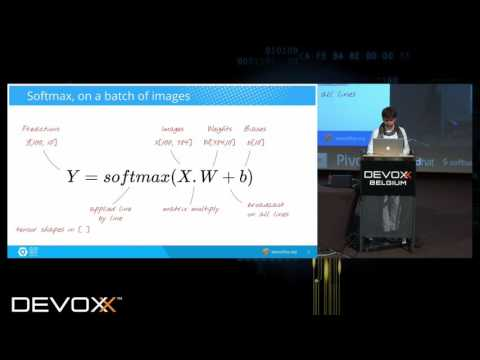

In [2]:
YouTubeVideo('vq2nnJ4g6N0')

# Importar y analizar dataset

In [3]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from fnn_helper import PlotLosses
from MNIST_helper import plot_numbers, visualize_input
from mlp_helper import plot_confusion_matrix
import draw_nn

Using TensorFlow backend.


## Importo el dataset

In [4]:
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]

In [5]:
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


## Grafico los 100 primeros dígitos

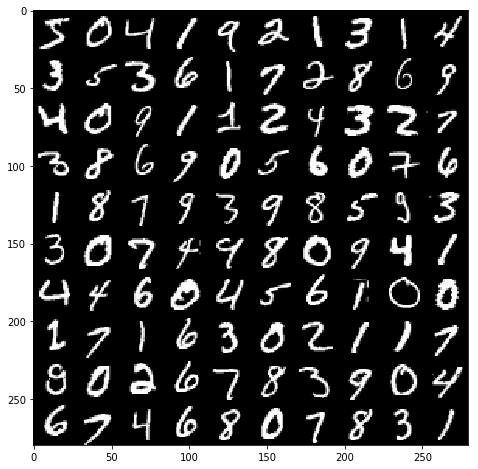

In [6]:
plot_numbers(x_train,range(100), columns=10, figsize=(8, 8))

## Vizualizo un dígito en escala de grises

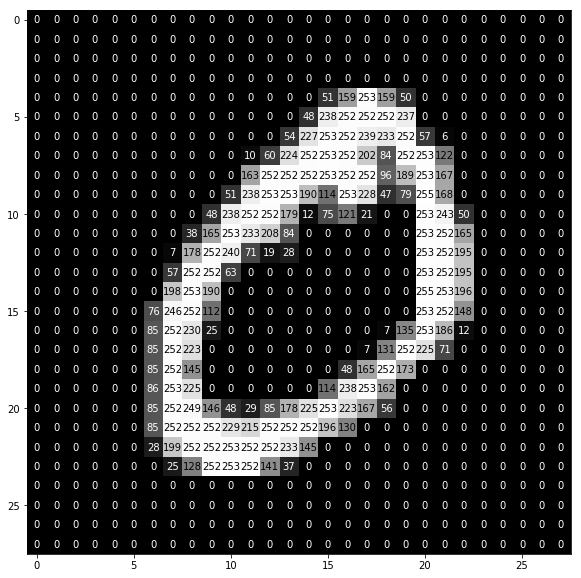

In [7]:
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_train[1], ax)
plt.show()

# Regresión logística multinomial

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_mldata

## Acomodo entrada

In [9]:
x_train_flattened = x_train.reshape(-1,784)
x_test_flattened = x_test.reshape(-1,784)

## Entreno clasificador

In [10]:
clf_logistic = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10, tol=0.05)
clf_logistic.fit(x_train_flattened, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.05, verbose=0, warm_start=False)

## Imprimo resultados

In [11]:
train_score_logistic = clf_logistic.score(x_train_flattened, y_train)
test_score_logistic = clf_logistic.score(x_test_flattened, y_test)
print(train_score_logistic, test_score_logistic)

0.9294166666666667 0.925


# Red Neuronal de 1 Capa (Regresión Logística)

## Diagrama

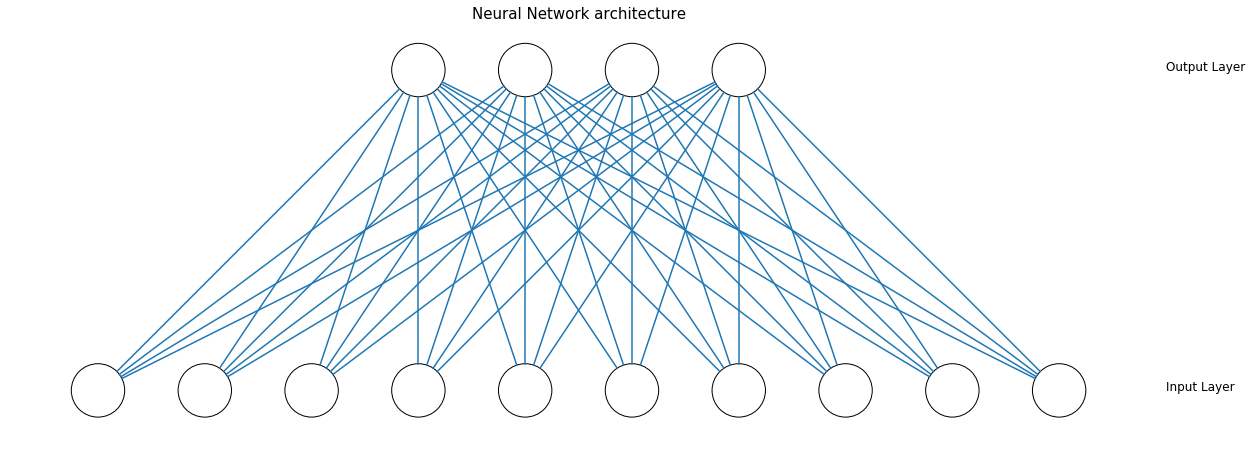

Realmente tengo 784 neuronas en la entrada y 10 en la salida


In [12]:
network = draw_nn.DrawNN( [10,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada y 10 en la salida")

In [13]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils import np_utils
import keras.backend as K

In [14]:
x_train.shape[1:]

(28, 28)

## Acomodo Salida: one-hot encoding

In [15]:
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[:5])

(48000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Definimos el modelo

In [16]:
x_train.shape

(48000, 28, 28)

In [17]:
output_size = 10

K.clear_session() # Necesario para usar tensorboard para que no de error al correrlo por segunda vez
# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:])) # Esta capa es opcional, se podria haber hecho el flatten antes
model_single_layer.add(Dense(output_size, kernel_initializer='zeros', name='Salida'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Compilamos el modelo
lr suele ser proporcional al mini-bath size. Es decir que si funciona con un lr y aumento el bs, deberia aumentar proporcionalmente el lr

In [18]:
# Compilo el modelo
lr = 0.00001 #0.01, 0.001, 0.00001, 0.000001, 0.00000001
#lr = 0.00000001
#lr = 0.01
SGD = optimizers.SGD(lr=lr, decay=1e-3)
model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])

Parámetros:
- Learning Rate (lr)
- Funciones de activación ([Activations](https://keras.io/activations/)): Sigmoid, Relu, [softmax](https://en.wikipedia.org/wiki/Softmax_function)
- Optimizers: [Keras](https://keras.io/optimizers/), [Articulo interesante](http://ruder.io/optimizing-gradient-descent/)
- Costo ([losses](https://keras.io/losses/))
- [Initializers](https://keras.io/initializers/)

## Exactitud del modelo sin entrenar

In [19]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.302585363006592
accuracy:  0.098


## Defino Callbacks
(No son estrictamente necesarias)

In [20]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='log_reg.mnist.hdf5', verbose=1, save_best_only=True)
tbCB = TensorBoard(log_dir='./logs_logistic_reg_'+str(int(time.time())), histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=True, write_images=True, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

## Entreno el modelo

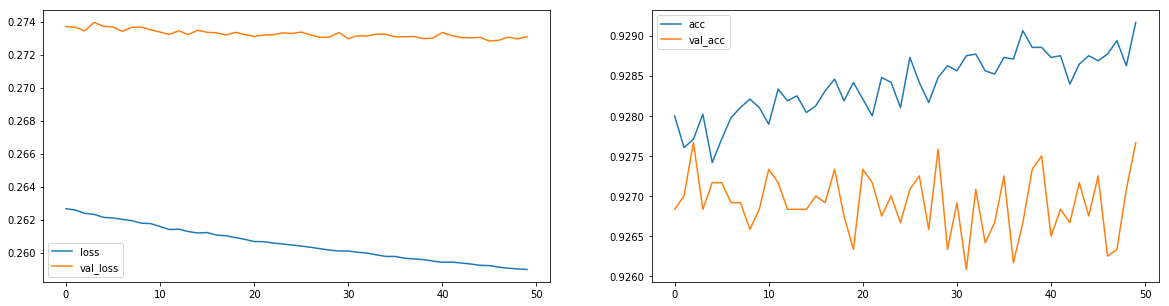


Epoch 00050: val_loss did not improve from 0.27282


In [22]:
batch_size = 1000
batch_size = 100
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=50, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[plot_losses, checkpointer, tbCB],
                      )

## Exactitud del modelo despues de entrenar

In [24]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.27604196759164334
accuracy:  0.9243


## Cargo pesos guardados
Los pesos fueron guardados con la clase ModelCheckpoint. Vamos a recuperarlos

In [23]:
# Cargo los valores del modelo
model_single_layer.load_weights('log_reg.mnist.hdf5')
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.27604196759164334
accuracy:  0.9243


## Analisis de los pesos

(784, 10)
[-2.01650601e-05  1.89588081e-05  1.35907185e-05 -2.03941636e-05
  3.44475620e-06  1.11913330e-04 -7.43461169e-06  4.03034028e-05
 -1.17793970e-04 -2.24225096e-05]


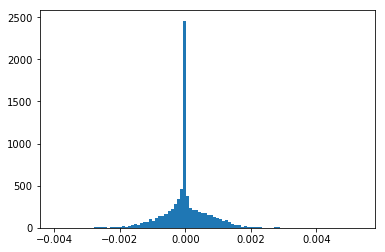

In [25]:
weights = model_single_layer.get_weights()[0]
biases = model_single_layer.get_weights()[1]
print(weights.shape)
print(biases)
plt.hist(weights.flatten(), 100)
plt.show()

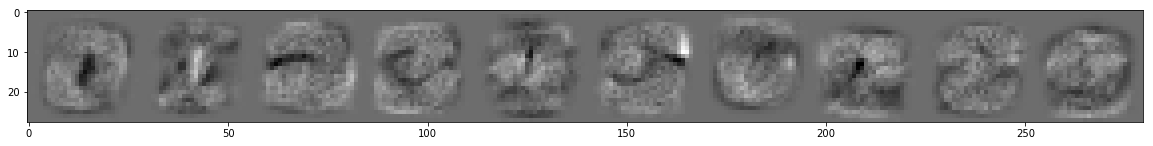

In [26]:
plt.figure(figsize=(20,20))
concatenated_weights = weights[:,0].reshape(28,28)
for wei in weights.T[1:10]:
    concatenated_weights = np.concatenate((concatenated_weights, wei.reshape(28,28)),axis=1 )
plt.imshow(concatenated_weights, cmap='gray')
plt.show()

## Analisis de dígitos errados

In [27]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [28]:
def get_sorted_errors(model):
    losses = []
    for i in range(len(x_test)):
        CE_loss = model.evaluate(x_test[i:i+1], y_test_categorical[i:i+1], verbose=0)[0]
        losses.append(CE_loss)
    predictions = model.predict(x_test)
    predicted_numbers = predictions.argmax(axis=1)
    sorted_loss_indexes = np.argsort(losses)[::-1]
    return predictions, predicted_numbers, sorted_loss_indexes

In [29]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model_single_layer)
print(predictions[:2])
print(predicted_numbers[:2])

[[1.7978789e-05 1.0428187e-10 3.3087832e-05 5.0654444e-03 5.4941427e-07
  7.7021032e-06 9.7902897e-10 9.9432015e-01 4.4174179e-05 5.1076541e-04]
 [8.4460923e-04 6.5011573e-06 9.8508322e-01 1.2787958e-03 1.8819408e-12
  3.2494043e-03 8.5987207e-03 8.2120844e-15 9.3872182e-04 7.8981634e-11]]
[7 2]


[(2, 7), (9, 0), (1, 5), (2, 6), (1, 2), (7, 2), (2, 4), (2, 4), (1, 3), (2, 7), (4, 0), (7, 2), (9, 0), (2, 4), (3, 8), (8, 4), (7, 1), (9, 0), (3, 9), (2, 7), (7, 8), (9, 0), (2, 6), (5, 8), (2, 8), (9, 5), (7, 2), (7, 1), (9, 3), (5, 6), (5, 0), (6, 5), (5, 0), (7, 2), (8, 7), (5, 8), (1, 2), (6, 0), (2, 9), (2, 8), (5, 6), (9, 0), (7, 2), (7, 1), (3, 7), (2, 8), (0, 7), (2, 4), (8, 4), (8, 3), (7, 3), (2, 3), (2, 6), (6, 1), (5, 1), (7, 2), (0, 3), (8, 4), (5, 6), (2, 0), (8, 0), (3, 5), (7, 8), (6, 0), (2, 6), (8, 5), (3, 6), (5, 2), (7, 2), (3, 8), (6, 0), (7, 2), (2, 3), (5, 4), (7, 4), (8, 6), (4, 2), (7, 2), (9, 3), (5, 4), (9, 7), (4, 2), (7, 9), (3, 5), (0, 5), (7, 3), (5, 6), (4, 8), (7, 2), (2, 9), (5, 9), (9, 3), (5, 8), (7, 2), (6, 4), (2, 0), (7, 9), (8, 6), (5, 2), (8, 7)]


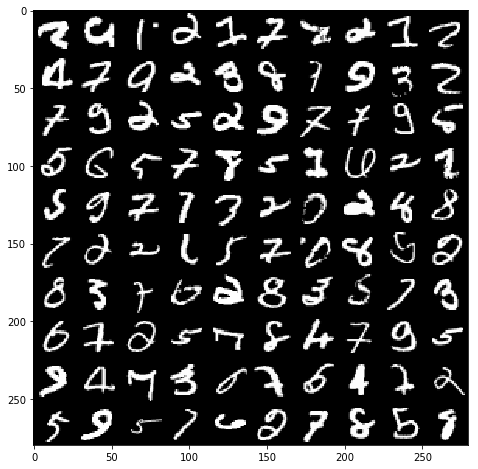

In [30]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

In [31]:
np.argmax(predictions, axis=1), y_test

(array([7, 2, 1, ..., 4, 5, 6]), array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))

Confusion matrix, without normalization


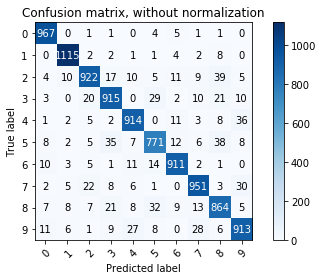

In [32]:
plot_confusion_matrix(y_test, np.argmax(predictions, axis=1), [i for i in range(10)])

# Red Neuronal de 2 capas (Una capa Oculta)

## Diagrama

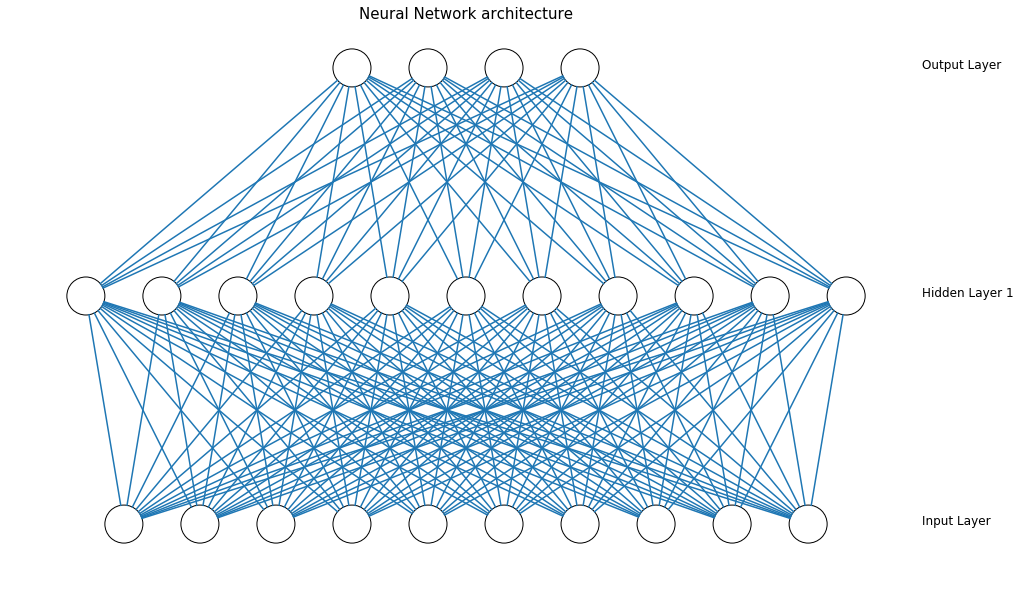

Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida


In [34]:
network = draw_nn.DrawNN( [10,11,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida")

## Definición y compilación del modelo

In [47]:
x_train.shape[1:]

(28, 28)

In [48]:
def two_layer_model(lr=0.000001, decay=0):    
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='sigmoid', kernel_initializer='zeros', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    SGD = optimizers.SGD(lr=lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model
K.clear_session()
model_two_layers = two_layer_model()
model_two_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle (Dense)               (None, 800)               628000    
_________________________________________________________________
Salida (Dense)               (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


## Calculo de la cantidad de parámetros
**¿de donde sale la cantidad de parámetros?**

In [49]:
first_layer = 784*800+800
print(first_layer)
last_layer = 800*10 + 10
print(last_layer)
print(first_layer+last_layer)

628000
8010
636010


## Evaluación antes de entrenar

In [50]:
score_two_layers = model_two_layers.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score_two_layers[0])
print("accuracy: ", score_two_layers[1])

loss:  2.4801527309417724
accuracy:  0.101


## Entrenamientos

### Learning rate = 0.01

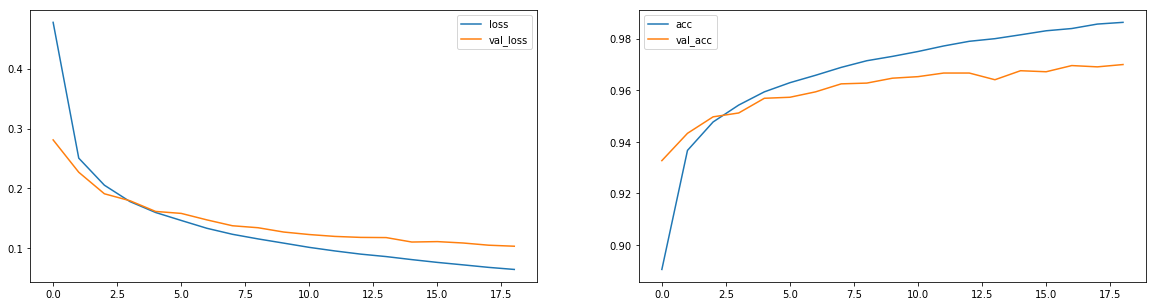


Epoch 00019: val_acc improved from 0.96960 to 0.97000, saving model to one-hidden.mnist.hdf5


In [ ]:
tbCB2 = TensorBoard(log_dir='./logs_one-hidden_'+str(int(time.time())), histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=True, write_images=False, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='one-hidden.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')

model_two_layers = two_layer_model(lr=0.01) # lr=0.000001, 
model_two_layers.fit(x_train, 
          y_train_categorical ,
          epochs=50, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer, tbCB2])

In [44]:
model_two_layers.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 1s 13us/step


[0.009032933659541111, 0.9991041666666667]

In [45]:
model_two_layers.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 14us/step


[0.08423268716195598, 0.9735]

In [38]:
model_two_layers.load_weights('one-hidden.mnist.hdf5')
model_two_layers.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 14us/step


[0.08248127222619951, 0.975]

(784, 800)
(800,)


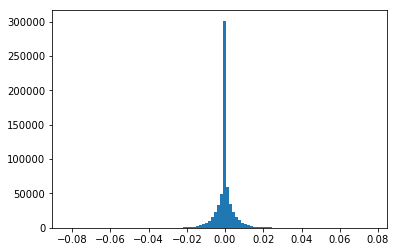

In [39]:
weights = model_two_layers.get_weights()[0]
biases = model_two_layers.get_weights()[1]
print(weights.shape)
print(biases.shape)
plt.hist(weights.flatten(), 100)
plt.show()

Confusion matrix, without normalization


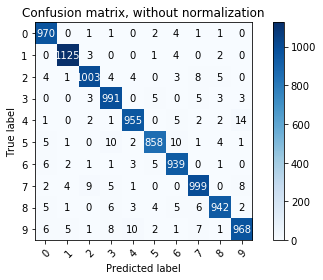

In [40]:
preds_two_layers = model_two_layers.predict(x_test)
plot_confusion_matrix(y_test, np.argmax(preds_two_layers, axis=1), [i for i in range(10)])

# Red Neuronal de 5 capas (4 ocultas)

## Activation: Relus
### Definición y compilación del modelo

In [41]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
K.clear_session()
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(100, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(60, activation='relu', kernel_initializer='normal', name='middle3'))
model.add(Dense(30, activation='relu', kernel_initializer='normal', name='middle4'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 100)               20100     
_________________________________________________________________
middle3 (Dense)              (None, 60)                6060      
_________________________________________________________________
middle4 (Dense)              (None, 30)                1830      
_________________________________________________________________
salida (Dense)               (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


In [42]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='four-hidden.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')

tbCB3 = TensorBoard(log_dir='./logs_four-hidden_'+str(int(time.time())), histogram_freq=1, batch_size=32, write_graph=True, 
                   write_grads=True, write_images=True, embeddings_freq=0, 
                   embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, 
                   update_freq='epoch')

model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento del modelo

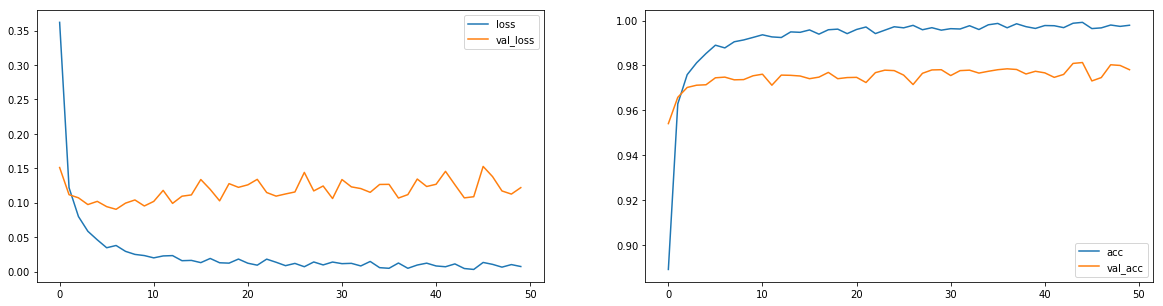


Epoch 00050: val_acc did not improve from 0.98130


In [398]:
model.fit(x_train, 
          y_train_categorical ,
          epochs=50, batch_size=256, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer, tbCB3],
         )

In [399]:
model.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 1s 14us/step


[0.006906139062375739, 0.9983541666666667]

In [400]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 16us/step


[0.12195321380897357, 0.9781]

In [43]:
model.load_weights('five-layer.mnist.hdf5')

In [44]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 17us/step


[0.1381119653036276, 0.982]

(784, 200)
(200,)


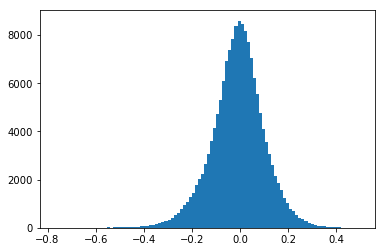

In [45]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]
print(weights.shape)
print(biases.shape)
plt.hist(weights.flatten(), 100)
plt.show()

### Resultados

In [46]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model)

[(4, 8), (4, 6), (9, 1), (7, 2), (2, 4), (5, 0), (7, 2), (4, 6), (9, 1), (5, 8), (8, 7), (4, 6), (3, 9), (6, 4), (6, 1), (2, 8), (2, 0), (2, 7), (9, 8), (5, 6), (3, 7), (3, 2), (9, 4), (8, 4), (2, 7), (4, 9), (5, 3), (2, 8), (3, 8), (4, 9), (6, 3), (4, 9), (7, 3), (6, 4), (7, 2), (4, 9), (8, 2), (9, 3), (5, 4), (1, 6), (4, 2), (2, 8), (6, 5), (1, 2), (5, 3), (3, 9), (4, 7), (2, 8), (6, 0), (2, 4), (2, 0), (5, 6), (9, 5), (8, 5), (8, 0), (7, 1), (3, 5), (2, 3), (3, 7), (0, 6), (4, 7), (0, 6), (8, 9), (8, 4), (7, 1), (0, 1), (5, 3), (4, 6), (9, 5), (0, 9), (8, 3), (0, 8), (6, 5), (9, 0), (8, 0), (6, 5), (8, 9), (7, 1), (7, 1), (9, 5), (5, 3), (8, 9), (9, 3), (4, 8), (2, 3), (7, 0), (7, 2), (8, 3), (5, 9), (2, 7), (2, 8), (8, 5), (3, 9), (7, 4), (3, 8), (6, 1), (3, 5), (7, 2), (8, 7), (8, 5)]


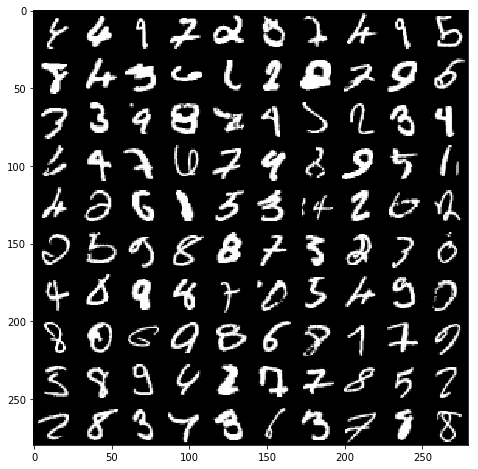

In [47]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

Confusion matrix, without normalization


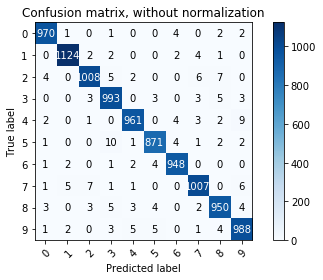

In [48]:
preds_last = model.predict(x_test)
plot_confusion_matrix(y_test, np.argmax(preds_last, axis=1), [i for i in range(10)])

# Limitaciones de MLP para clasificación de imágenes:
- Cantidad muy grande de parametros
- Se pierden las relaciones originales de los pixeles adyacentes (flatten). 